<a href="https://colab.research.google.com/github/LeeMooHeon/Final-Team10/blob/main/10%ED%8C%80_%EC%9D%B4%EB%AC%B4%ED%97%8C_%EC%B6%94%EC%B2%9C_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98_by_user.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Colab 환경 고정 세팅 (항상 맨 위에 실행!)
!pip install -q numpy==1.26.4
!pip install -q scikit-surprise==1.1.3
!pip install -q optuna==3.6.1

import numpy as np, pandas as pd, optuna
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

print("✅ 환경 세팅 완료 (numpy 1.26.4 / scikit-surprise 1.1.3 / optuna 3.6.1)")


✅ 환경 세팅 완료 (numpy 1.26.4 / scikit-surprise 1.1.3 / optuna 3.6.1)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)  # 모든 컬럼 표시
pd.set_option("display.width", 2000)        # 한 줄에 표시할 폭 늘리기
pd.set_option("display.max_colwidth", None) # 문자열 잘림 방지

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# **한글**

In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# **데이터 불러오기 및 전처리**

In [5]:
from google.colab import drive
import pandas as pd


# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. 데이터 불러오기
base_path = "/content/drive/MyDrive"

links = pd.read_csv(f"{base_path}/links.csv")
movies = pd.read_csv(f"{base_path}/movies.csv")
ratings = pd.read_csv(f"{base_path}/ratings.csv")
tags = pd.read_csv(f"{base_path}/tags.csv")



# 확인
#print(links.shape, movies.shape, ratings.shape, tags.shape)
#

Mounted at /content/drive


In [6]:
# timestamp → datetime 변환
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# 2020년 이후 데이터만 사용
cutoff_date = pd.Timestamp('2020-01-01')
ratings = ratings[ratings['timestamp'] >= cutoff_date].copy()
tags = tags[tags['timestamp'] >= cutoff_date].copy()

# ratings에 존재하는 영화만 필터링
movie_ids = ratings['movieId'].unique()
movies = movies[movies['movieId'].isin(movie_ids)].copy()
links = links[links['movieId'].isin(movie_ids)].copy()

# 마지막 날짜 확인
last_rating_date = ratings['timestamp'].max()
last_tag_date = tags['timestamp'].max()

# 확인 출력
print("ratings shape:", ratings.shape)
#print("tags shape:", tags.shape)
#print("movies shape:", movies.shape)
#print("links shape:", links.shape)
#print("ratings 마지막 날짜:", last_rating_date)
#print("tags 마지막 날짜:", last_tag_date)


ratings shape: (4635230, 4)


# **Heavy Rater 가중치 설정**

In [7]:
# 유저별 평점 개수
user_stats = ratings.groupby("userId").agg(rating_count=("rating","count")).reset_index()

# 상위 10% 이상 → 헤비 레이터
threshold = np.percentile(user_stats["rating_count"], 90)
heavy_raters = set(user_stats[user_stats["rating_count"] >= threshold]["userId"])


# **Content Age 가중치 설정**

In [8]:
# 영화 개봉연도 추출
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# 콘텐츠 연령 계산
ratings = ratings.merge(movies[['movieId','release_year']], on='movieId', how='left')
ratings['rating_year'] = ratings['timestamp'].dt.year
ratings['content_age'] = ratings['rating_year'] - ratings['release_year']

# 유저별 평균 콘텐츠 연령
user_age_pref = ratings.groupby('userId')['content_age'].mean().reset_index()
median_age = user_age_pref['content_age'].median()

# 트렌드 vs 레트로 성향
user_age_pref['age_pref'] = np.where(
    user_age_pref['content_age'] >= median_age, "retro", "trend"
)

# 유저 성향 합치기
ratings = ratings.merge(user_age_pref[['userId','age_pref']], on='userId', how='left')


# **장르 선호도 가중치 설정**

In [9]:
# 장르 분리
movies['genres_list'] = movies['genres'].str.split('|')

if 'genres_list' in ratings.columns:
    ratings = ratings.drop(columns=['genres_list'])

ratings = ratings.merge(movies[['movieId','genres_list']], on='movieId', how='left')
ratings_exploded = ratings.explode('genres_list')

# 유저별 장르 평균 평점
user_genre_pref = (
    ratings_exploded.groupby(['userId','genres_list'])['rating']
    .mean().reset_index()
)

# 상위 10% 장르 플래그
def top_genres(df):
    cutoff = np.percentile(df['rating'], 90)
    df['is_top_genre'] = np.where(df['rating'] >= cutoff, 1, 0)
    return df

user_genre_pref = (
    user_genre_pref.groupby('userId')
    .apply(top_genres).reset_index(drop=True)
)

# Top Genre 플래그 합치기
ratings_exploded = ratings_exploded.merge(
    user_genre_pref[['userId','genres_list','is_top_genre']],
    on=['userId','genres_list'], how='left'
)


/tmp/ipython-input-4154782406.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(top_genres).reset_index(drop=True)


# **Optuna SVD**

In [10]:
!pip install -q optuna scikit-surprise==1.1.3
!pip install -q numpy==1.26.4

import numpy as np, pandas as pd, optuna
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# 기본 설정
N_TRIALS = 15            # Optuna 탐색 횟수
SAMPLE_USERS = 6000      # 유저 샘플 수
SAMPLE_MOVIES = 12000    # 영화 샘플 수
RAND_SEED = 42
np.random.seed(RAND_SEED)

# 최적화용 데이터 샘플링
u_pool = ratings_exploded['userId'].unique()
m_pool = ratings_exploded['movieId'].unique()
u_sub = set(np.random.choice(u_pool, min(SAMPLE_USERS, len(u_pool)), replace=False))
m_sub = set(np.random.choice(m_pool, min(SAMPLE_MOVIES, len(m_pool)), replace=False))
opt_df = ratings_exploded[
    ratings_exploded['userId'].isin(u_sub) & ratings_exploded['movieId'].isin(m_sub)
].copy()

# Surprise 데이터셋 생성
def make_surprise_data(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    return Dataset.load_from_df(df[['userId','movieId','rating']], reader)

# 가중치 반영
def build_weighted_df(df, hr, ca, tg):
    w_hr = np.where(df['userId'].isin(heavy_raters), hr, 1.0)

    if 'age_pref' in df.columns:
        is_trend = df['age_pref'].astype(str).str.contains('trend|신작', case=False, regex=True)
        w_ca = np.where(is_trend, ca, 1.0)
    else:
        w_ca = 1.0

    w_tg = np.where(df.get('is_top_genre', 0) == 1, tg, 1.0)

    w = w_hr * w_ca * w_tg
    wr = (df['rating'] * w).clip(0.5, 5.0)

    out = df[['userId','movieId']].copy()
    out['rating'] = wr
    return out

# Optuna 목적 함수
def objective(trial):
    hr = trial.suggest_float('HR', 0.9, 1.3)
    ca = trial.suggest_float('CA', 0.9, 1.3)
    tg = trial.suggest_float('TG', 0.9, 1.3)

    df_w = build_weighted_df(opt_df, hr, ca, tg)
    data = make_surprise_data(df_w)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=RAND_SEED)

    model = SVD(n_factors=40, n_epochs=15, random_state=RAND_SEED, reg_all=0.01)
    model.fit(trainset)
    preds = model.test(testset)
    return accuracy.rmse(preds, verbose=False)

# Optuna 실행
sampler = optuna.samplers.TPESampler(seed=RAND_SEED)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("Best params:", best_params, "| Best RMSE:", study.best_value)

# 최적 파라미터로 풀데이터 재학습
full_df_w = build_weighted_df(ratings_exploded, best_params['HR'], best_params['CA'], best_params['TG'])
full_data = make_surprise_data(full_df_w)
trainset, testset = train_test_split(full_data, test_size=0.2, random_state=RAND_SEED)

final_model = SVD(n_factors=100, n_epochs=25, random_state=RAND_SEED, reg_all=0.01)
final_model.fit(trainset)
final_preds = final_model.test(testset)
print("Final RMSE:", accuracy.rmse(final_preds, verbose=False))
print("Final MAE :", accuracy.mae(final_preds, verbose=False))

# 추천 함수
def recommend_for_user_optuna(user_id, top_n=10):
    seen = set(full_df_w.loc[full_df_w['userId']==user_id, 'movieId'])
    candidates = full_df_w['movieId'].unique()

    preds = [(mid, final_model.predict(user_id, mid).est) for mid in candidates if mid not in seen]
    top = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(top, columns=['movieId','pred_rating']).merge(
        movies[['movieId','title']], on='movieId', how='left'
    )

# 샘플 유저 추천
sample_user = int(full_df_w['userId'].sample(1, random_state=RAND_SEED).iloc[0])
print("추천 테스트 유저:", sample_user)
print(recommend_for_user_optuna(sample_user, top_n=10))


[I 2025-09-30 22:23:59,052] A new study created in memory with name: no-name-7f45dd43-9076-4712-82e4-4f035d51689a


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-09-30 22:24:04,103] Trial 0 finished with value: 0.5943996844028451 and parameters: {'HR': 1.049816047538945, 'CA': 1.2802857225639666, 'TG': 1.192797576724562}. Best is trial 0 with value: 0.5943996844028451.
[I 2025-09-30 22:24:09,296] Trial 1 finished with value: 0.5911907150783114 and parameters: {'HR': 1.1394633936788146, 'CA': 0.9624074561769747, 'TG': 0.9623978081344811}. Best is trial 1 with value: 0.5911907150783114.
[I 2025-09-30 22:24:14,387] Trial 2 finished with value: 0.5816178483698908 and parameters: {'HR': 0.9232334448672798, 'CA': 1.2464704583099742, 'TG': 1.1404460046972835}. Best is trial 2 with value: 0.5816178483698908.
[I 2025-09-30 22:24:19,369] Trial 3 finished with value: 0.6053520272496992 and parameters: {'HR': 1.1832290311184182, 'CA': 0.908233797718321, 'TG': 1.2879639408647978}. Best is trial 2 with value: 0.5816178483698908.
[I 2025-09-30 22:24:24,576] Trial 4 finished with value: 0.597405898997323 and parameters: {'HR': 1.2329770563201687, 'CA':

# **모델 검증 (추천 점수 분포, 시청 기록 없는 영화인지 확인)**

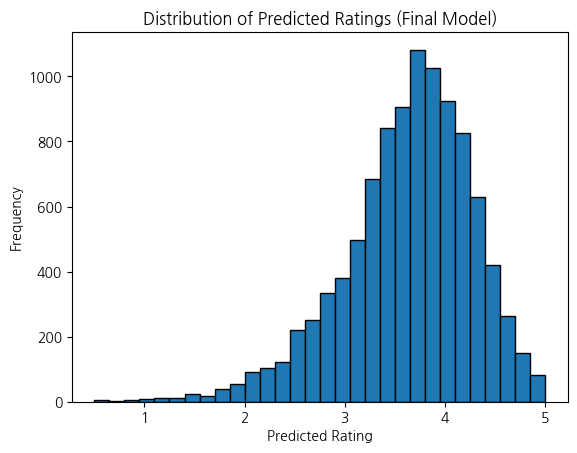

In [11]:
import matplotlib.pyplot as plt

# 전체 예측값 샘플링
sample_users = np.random.choice(full_df_w['userId'].unique(), 200, replace=False)
sample_movies = np.random.choice(full_df_w['movieId'].unique(), 50, replace=False)

preds = []
for uid in sample_users:
    for mid in sample_movies:
        preds.append(final_model.predict(uid, mid).est)

# 히스토그램
plt.hist(preds, bins=30, edgecolor='black')
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Ratings (Final Model)")
plt.show()


In [12]:
# 특정 유저 선택 (예: 방금 추천한 유저)
user_id = sample_user

# 추천된 영화
recs = recommend_for_user_optuna(user_id, top_n=10)

# 실제로 본 영화 (훈련+테스트 모두 포함)
seen_movies = set(ratings_exploded.loc[ratings_exploded['userId']==user_id, 'movieId'].unique())

# 교집합 확인
overlap = set(recs['movieId']) & seen_movies

print("추천 결과")
print(recs)
print("\n이미 본 영화 수:", len(seen_movies))
print("추천된 영화 중 이미 본 영화 수:", len(overlap))
print("겹치는 영화 목록:", overlap)


추천 결과
   movieId  pred_rating                                                           title
0      541          5.0                                             Blade Runner (1982)
1   126430          5.0                                              The Pacific (2010)
2   212373          5.0                                   I'm Thinking of Ending Things
3      293          5.0  Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
4     4546          5.0                               Vanishing, The (Spoorloos) (1988)
5     2324          5.0                      Life Is Beautiful (La Vita è bella) (1997)
6     5995          5.0                                             Pianist, The (2002)
7     2985          5.0                                                  RoboCop (1987)
8     1172          5.0                  Cinema Paradiso (Nuovo cinema Paradiso) (1989)
9     1280          5.0    Raise the Red Lantern (Da hong deng long gao gao gua) (1991)

이미 본 영화 수: 91
추천된 영화 중 이미

# **테스트 시각화**

In [13]:
# 영화별 평점 통계 (count, mean)
movie_stats = ratings.groupby("movieId").agg(
    count=("rating","count"),
    mean_rating=("rating","mean")
).reset_index()

def recommend_for_user_fast(user_id, top_n=10, weighted=True, min_count=50, sample_size=None):
    """
    user_id에 대해 보정 전/후 추천 결과 반환 (빠른 버전)

    Args:
        user_id: 추천할 유저 ID
        top_n: 추천 개수
        weighted: 보정 여부 (True=보정 후, False=보정 전)
        min_count: 후보 영화 최소 평점 수 (default=50 이상만 허용)
        sample_size: 후보 영화 샘플 개수 (None이면 전체 사용)
    """

    seen = set(full_df_w.loc[full_df_w['userId']==user_id, 'movieId'])

    # 후보 영화 pool (평점 n개 이상 받은 영화만)
    valid_movies = movie_stats.loc[movie_stats['count'] >= min_count, 'movieId']
    candidates = [mid for mid in valid_movies if mid not in seen]

    # 후보 샘플링 (속도 개선)
    if sample_size and len(candidates) > sample_size:
        candidates = np.random.choice(candidates, size=sample_size, replace=False)

    # Surprise 형식 testset 생성
    testset = [(user_id, int(mid), 0) for mid in candidates]  # dummy rating=0
    preds = final_model.test(testset)  # 한 번에 예측

    results = []
    for p in preds:
        mid, est = int(p.iid), p.est
        if weighted:
            # 유저 속성 기반 가중치
            hr = 1.2 if user_id in heavy_raters else 1.0
            ca = 1.2 if user_age_pref.loc[user_age_pref['userId']==user_id, 'age_pref'].iloc[0] == "trend" else 1.0
            tg = 1.2 if ratings_exploded[
                (ratings_exploded['userId']==user_id) &
                (ratings_exploded['movieId']==mid)
            ]['is_top_genre'].any() else 1.0
            est *= hr * ca * tg
        results.append((mid, est))

    # 정렬 후 상위 N
    top = sorted(results, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(top, columns=['movieId','pred_rating']).merge(
        movies[['movieId','title']], on='movieId', how='left'
    )

# 샘플 유저 추천 테스트
sample_user = int(full_df_w['userId'].sample(1, random_state=42).iloc[0])
print("샘플 유저:", sample_user)

print("\n[보정 전 추천 결과]")
display(recommend_for_user_fast(sample_user, top_n=10, weighted=False, sample_size=2000))

print("\n[보정 후 추천 결과]")
display(recommend_for_user_fast(sample_user, top_n=10, weighted=True, sample_size=2000))


샘플 유저: 55550

[보정 전 추천 결과]


,movieId,pred_rating,title
0,2324,5.000000,Life Is Beautiful (La Vita è bella) (1997)
1,5995,5.000000,"Pianist, The (2002)"
2,187531,4.962111,John Mulaney: Kid Gorgeous at Radio City (2018)
3,261955,4.961429,The Rescue (2021)
4,94959,4.947178,Moonrise Kingdom (2012)
5,80969,4.922487,Never Let Me Go (2010)
6,1913,4.901042,Picnic at Hanging Rock (1975)
7,171011,4.834956,Planet Earth II (2016)
8,110501,4.828821,The Raid 2: Berandal (2014)
9,4848,4.823293,Mulholland Drive (2001)



[보정 후 추천 결과]


,movieId,pred_rating,title
0,2324,6.000000,Life Is Beautiful (La Vita è bella) (1997)
1,126430,6.000000,The Pacific (2010)
2,4546,6.000000,"Vanishing, The (Spoorloos) (1988)"
3,2985,6.000000,RoboCop (1987)
4,1172,6.000000,Cinema Paradiso (Nuovo cinema Paradiso) (1989)
5,27834,5.954991,"Return, The (Vozvrashcheniye) (2003)"
6,261955,5.953714,The Rescue (2021)
7,80969,5.906984,Never Let Me Go (2010)
8,1913,5.881250,Picnic at Hanging Rock (1975)
9,46855,5.840988,Army of Shadows (L'armée des ombres) (1969)


# **랜덤 유저 2명 비교 시각화 (168965 vs 29086)**

In [15]:
def compare_recommendations(user_id, top_n=5, sample_size=5000):
    """특정 유저에 대해 보정 전/후/실제 평점 비교 (Optuna 최적 가중치 반영)"""

    seen = set(full_df_w.loc[full_df_w['userId'] == user_id, 'movieId'])

    # 후보 pool (평점 50개 이상 받은 영화만)
    valid_movies = movie_stats.loc[movie_stats['count'] >= 50, 'movieId']
    candidates = [mid for mid in valid_movies if mid not in seen]

    # 속도 개선용 샘플링
    if sample_size and len(candidates) > sample_size:
        candidates = np.random.choice(candidates, size=sample_size, replace=False)

    # Surprise testset
    testset = [(user_id, int(mid), 0) for mid in candidates]
    preds = final_model.test(testset)

    rows = []
    for p in preds:
        mid, est = int(p.iid), p.est

        # 보정 전
        pred_before = est

        # 보정 후 (Optuna 최적 파라미터 적용)
        hr_w = best_params['HR']
        ca_w = best_params['CA']
        tg_w = best_params['TG']

        hr = hr_w if user_id in heavy_raters else 1.0
        ca = ca_w if user_age_pref.loc[user_age_pref['userId'] == user_id, 'age_pref'].iloc[0] == "trend" else 1.0
        tg = tg_w if ratings_exploded[
            (ratings_exploded['userId'] == user_id) &
            (ratings_exploded['movieId'] == mid)
        ]['is_top_genre'].any() else 1.0

        pred_after = est * hr * ca * tg

        # 실제 평균 평점 & 개수
        if mid in movie_stats.set_index("movieId").index:
            mean_rating = movie_stats.loc[movie_stats["movieId"] == mid, "mean_rating"].values[0]
            count = int(movie_stats.loc[movie_stats["movieId"] == mid, "count"].values[0])
        else:
            mean_rating, count = np.nan, 0

        title = movies.loc[movies["movieId"] == mid, "title"].values[0] if mid in movies["movieId"].values else "Unknown"

        rows.append((mid, title, pred_before, pred_after, mean_rating, count))

    df_out = pd.DataFrame(rows, columns=["movieId","title","pred_before","pred_after","mean_rating","count"])
    df_out = df_out.sort_values("count", ascending=False).head(top_n)
    return df_out





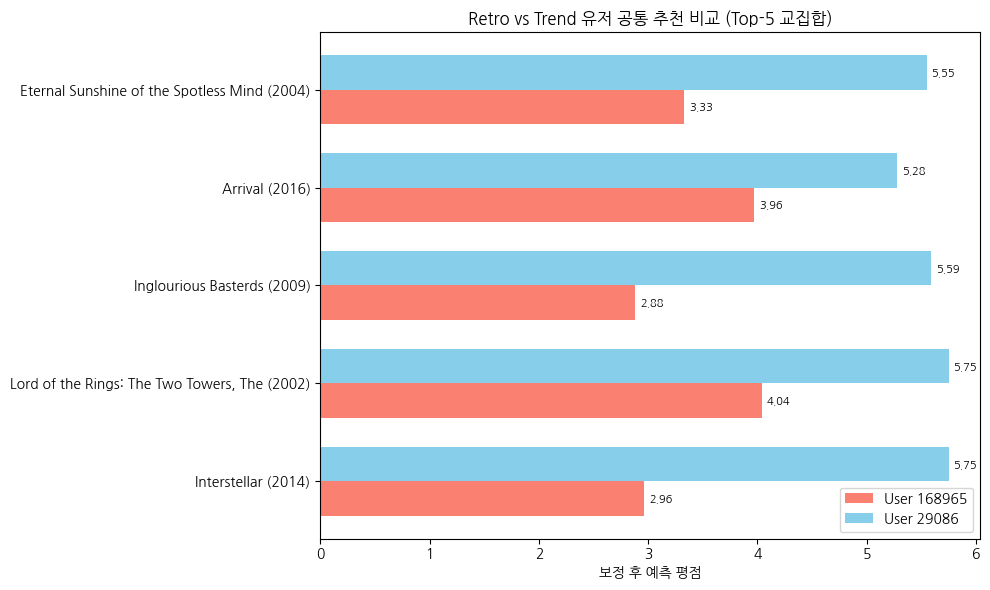

🎬 두 유저 공통 추천 비교표 (Top-5 교집합)
User 168965 성향 → HR✗, CA:retro, TG:Mystery,Sci-Fi
User 29086 성향 → HR✗, CA:trend, TG:Horror,Romance,Sci-Fi



,title,User 168965,User 29086
0,Interstellar (2014),2.963027,5.748540
1,"Lord of the Rings: The Two Towers, The (2002)",4.037731,5.748540
2,Inglourious Basterds (2009),2.876697,5.589589
3,Arrival (2016),3.964543,5.276208
4,Eternal Sunshine of the Spotless Mind (2004),3.326958,5.548151


In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -------------------------------------
# 🔑 캐싱 딕셔너리 (중복 계산 방지)
# -------------------------------------
cache = {}

def fast_compare(u, k=20):
    """유저 추천 결과 (Top-k) 캐싱"""
    if u not in cache:
        cache[u] = compare_recommendations(u, top_n=k)
    return cache[u]


# -------------------------------------
# 🔑 Retro 1명 + Trend 1명 뽑기
# -------------------------------------
def get_retro_trend_pair(k=20, needed=5):
    retro_user = user_age_pref[user_age_pref['age_pref']=="retro"].sample(1).iloc[0]['userId']
    trend_user = user_age_pref[user_age_pref['age_pref']=="trend"].sample(1).iloc[0]['userId']
    sample_users = [int(retro_user), int(trend_user)]

    results = {u: fast_compare(u, k) for u in sample_users}

    # 교집합 계산
    left_titles = set(results[sample_users[0]]["title"])
    right_titles = set(results[sample_users[1]]["title"])
    common = list(left_titles & right_titles)

    if len(common) < needed:
        raise ValueError(f"❌ 교집합이 {needed}개 미만입니다. (현재 {len(common)}개)")

    return sample_users, results, common[:needed]


# -------------------------------------
# 🔍 유저 성향 출력
# -------------------------------------
def get_user_traits(user_id):
    hr = "HR✓" if user_id in heavy_raters else "HR✗"
    ca_pref = user_age_pref.loc[user_age_pref['userId'] == user_id, 'age_pref'].iloc[0]
    ca = f"CA:{ca_pref}"
    tg_genres = (
        user_genre_pref
        .loc[(user_genre_pref['userId']==user_id) & (user_genre_pref['is_top_genre']==1), 'genres_list']
        .tolist()
    )
    tg = f"TG:{','.join(tg_genres) if tg_genres else '없음'}"
    return hr, ca, tg


# -------------------------------------
# 📑 교집합 표
# -------------------------------------
def results_to_table_common(results, sample_users, common_titles):
    df_left = results[sample_users[0]][["title","pred_after"]].rename(
        columns={"pred_after": f"User {sample_users[0]}"}
    )
    df_right = results[sample_users[1]][["title","pred_after"]].rename(
        columns={"pred_after": f"User {sample_users[1]}"}
    )

    merged = pd.merge(df_left, df_right, on="title", how="inner")
    merged = merged[merged["title"].isin(common_titles)].reset_index(drop=True)

    # 성향 요약
    traits = {}
    for u in sample_users:
        hr, ca, tg = get_user_traits(u)
        traits[u] = f"{hr}, {ca}, {tg}"

    print("🎬 두 유저 공통 추천 비교표 (Top-5 교집합)")
    print(f"User {sample_users[0]} 성향 → {traits[sample_users[0]]}")
    print(f"User {sample_users[1]} 성향 → {traits[sample_users[1]]}\n")

    return merged


# -------------------------------------
# 📊 교집합 시각화
# -------------------------------------
def plot_two_users_common(results, sample_users, common_titles):
    colors = ["salmon", "skyblue"]
    h = 0.35

    df_left = results[sample_users[0]][["title","pred_after"]].rename(
        columns={"pred_after": f"User {sample_users[0]}"}
    )
    df_right = results[sample_users[1]][["title","pred_after"]].rename(
        columns={"pred_after": f"User {sample_users[1]}"}
    )
    merged = pd.merge(df_left, df_right, on="title", how="inner")
    merged = merged[merged["title"].isin(common_titles)].reset_index(drop=True)

    plt.figure(figsize=(10,6))
    x = np.arange(len(merged))

    plt.barh(x - h/2, merged[f"User {sample_users[0]}"], height=h, color="salmon", label=f"User {sample_users[0]}")
    plt.barh(x + h/2, merged[f"User {sample_users[1]}"], height=h, color="skyblue", label=f"User {sample_users[1]}")

    # 값 표시
    for i, val in enumerate(merged[f"User {sample_users[0]}"]):
        plt.text(val+0.05, i - h/2, f"{val:.2f}", va="center", fontsize=8)
    for i, val in enumerate(merged[f"User {sample_users[1]}"]):
        plt.text(val+0.05, i + h/2, f"{val:.2f}", va="center", fontsize=8)

    plt.yticks(x, merged["title"])
    plt.xlabel("보정 후 예측 평점")
    plt.title("Retro vs Trend 유저 공통 추천 비교 (Top-5 교집합)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -------------------------------------
# 🚀 실행
# -------------------------------------
sample_users, results, common_titles = get_retro_trend_pair(k=20, needed=5)

plot_two_users_common(results, sample_users, common_titles)
table_common = results_to_table_common(results, sample_users, common_titles)
display(table_common)
